# Autoencoder MNIST

## Importing required packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from  torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim
from torchvision import datasets,transforms

## Defining transforms

In [2]:
transforms=transforms.ToTensor()

## Downloading requried data

In [3]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transforms)
test_data=datasets.MNIST('data',train=False,download=True,transform=transforms)

## Defining dataloaders

In [4]:
valid_size=0.2

# IMPORTANT 
batch_size=20

num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [5]:
# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [6]:
# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch

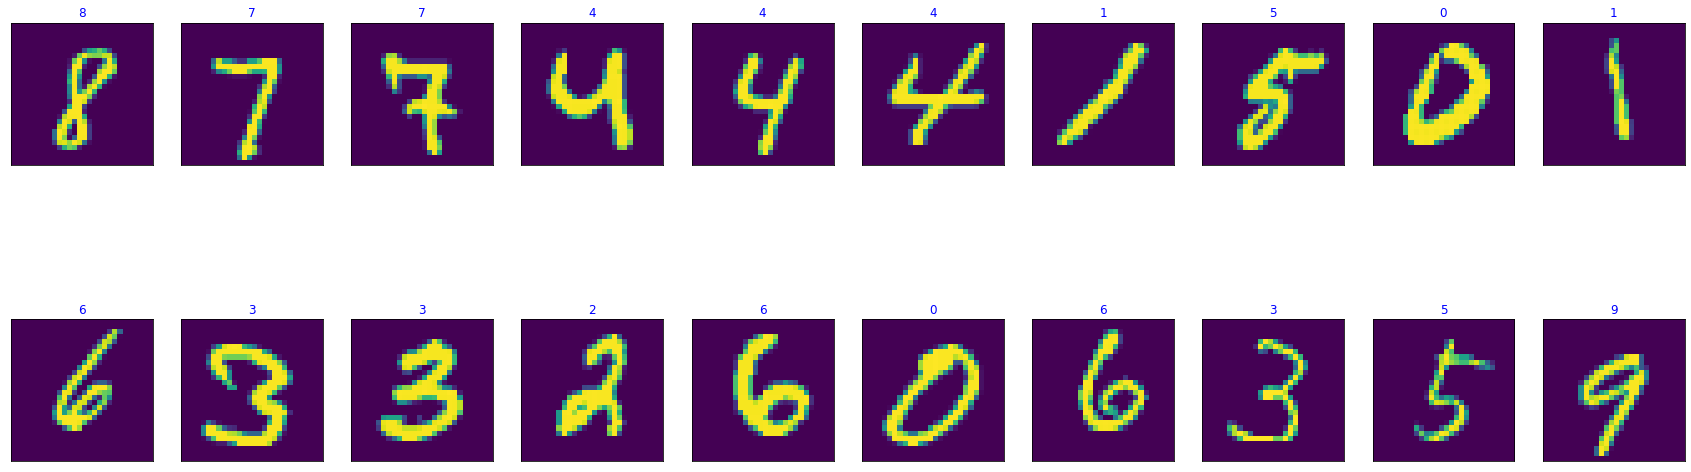

In [7]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

## Defining Architecture

In [8]:
class F_Auto_MNIST(nn.Module):
    def __init__(self,en_dim):
        super(F_Auto_MNIST,self).__init__()
        self.encoder=nn.Linear(784,en_dim)
        self.decoder=nn.Linear(en_dim,784)
    
    def forward(self,x):
        x=F.relu(self.encoder(x))
        x=F.sigmoid(self.decoder(x))
        return x

In [9]:
model_1=F_Auto_MNIST(32)

def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model_1.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
print(model_1,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

AutoMNIST(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
) 



 On GPU :  True


## Defining our Loss Function

In [10]:
criterion=nn.MSELoss()

## Training and Validation Phase

In [11]:
def trainNet(model,lr):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=20

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,_ in train_loader:
            if use_cuda and torch.cuda.is_available():
                images=images.cuda()
            images=images.view(images.size(0),-1)
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,images)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,_ in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images=images.cuda()
            images=images.view(images.size(0),-1)
            output=model(images)
            loss=criterion(output,images)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)

In [12]:
m1_loss=trainNet(model_1,0.01)


Epoch : 1	Training Loss : 0.030122794842657945	Validation Loss : 0.02710638804361224
Validation loss decreased from : inf ----> 0.02710638804361224 ----> Saving Model.......

Epoch : 2	Training Loss : 0.026202507383810976	Validation Loss : 0.025701081876953445
Validation loss decreased from : 0.02710638804361224 ----> 0.025701081876953445 ----> Saving Model.......

Epoch : 3	Training Loss : 0.0259379151238439	Validation Loss : 0.026007676074902217

Epoch : 4	Training Loss : 0.02578391444403678	Validation Loss : 0.026079511931166054

Epoch : 5	Training Loss : 0.025735000000180055	Validation Loss : 0.02581441594287753

Epoch : 6	Training Loss : 0.025659377567935734	Validation Loss : 0.025701422231892746

Epoch : 7	Training Loss : 0.025651658098213376	Validation Loss : 0.025555414784078797
Validation loss decreased from : 0.025701081876953445 ----> 0.025555414784078797 ----> Saving Model.......

Epoch : 8	Training Loss : 0.025607035839930178	Validation Loss : 0.02551746618002653
Validati

In [12]:
model_1.load_state_dict(torch.load('AutoMNIST_model.pth'))

<All keys matched successfully>

## Testing Phase

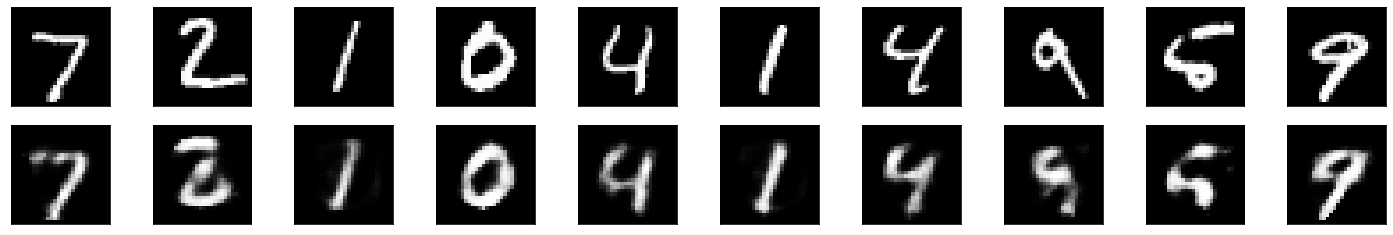

In [19]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
if use_cuda and torch.cuda.is_available():
    images=images.cuda()
    
images_flatten = images.view(images.size(0), -1)

# get sample outputs
output = model_1(images_flatten)
# prep images for display
images = images.cpu().numpy()
# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()


# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        